In [10]:
import numpy as np
import pandas as pd
import os
from glob import glob
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
start_root = 'C:/Users/monke/Downloads/vinbigdata/'

In [12]:
train_df = pd.read_csv(f'{start_root}train.csv')

In [13]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [14]:
train_df.image_id.nunique()

15000

In [15]:
for item in train_df.class_name.unique():
    num = train_df[train_df.class_name == item].image_id.nunique()
    print(item, num)

No finding 10606
Cardiomegaly 2300
Aortic enlargement 3067
Pleural thickening 1981
ILD 386
Nodule/Mass 826
Pulmonary fibrosis 1617
Lung Opacity 1322
Atelectasis 186
Other lesion 1134
Infiltration 613
Pleural effusion 1032
Calcification 452
Consolidation 353
Pneumothorax 96


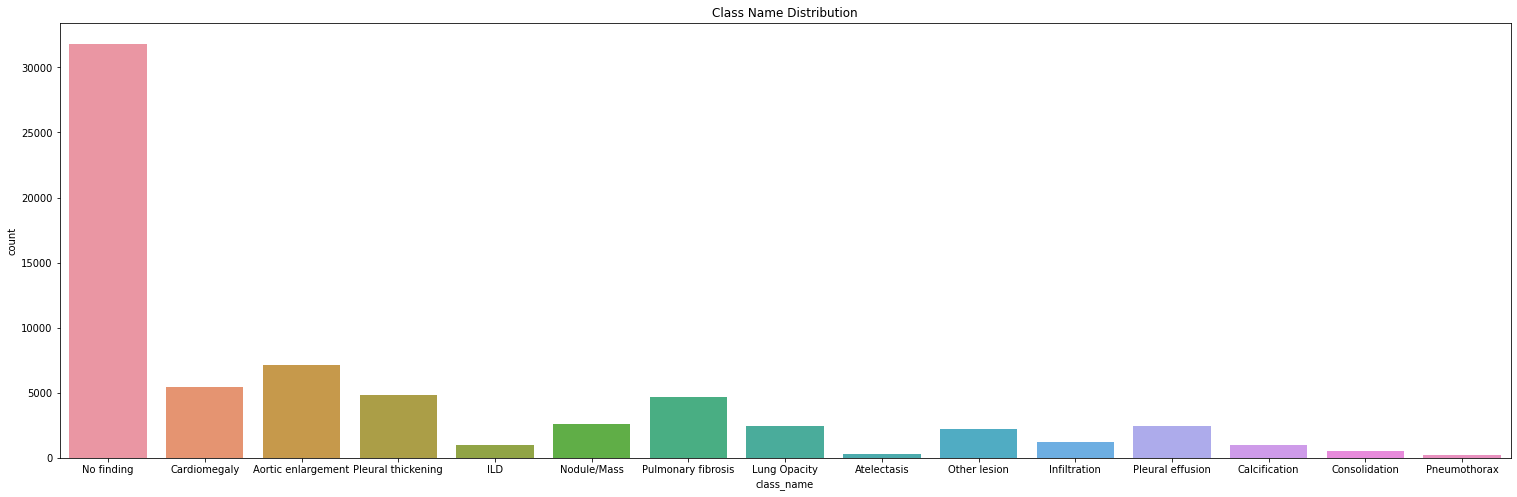

In [16]:
plt.figure(figsize = (26, 8))
sns.countplot(x = 'class_name', data = train_df)
plt.title("Class Name Distribution")
plt.show()

In [17]:
os.getcwd()

'C:\\Xray'

In [21]:
data_path = 'C:/Xray/data'

In [22]:
def make_dir(name):
    if not os.path.isdir(name):
        os.mkdir(name)
        print(name, "active")
    else:
        print("Already exists")

In [23]:
make_dir(data_path)

C:/Xray/data active


In [28]:
import pydicom
from tqdm import tqdm
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [29]:
train_dir = 'C:/Users/monke/Downloads/vinbigdata/train'

In [30]:
train_dicom_files = glob(f"{train_dir}/*.dicom")
print(f"Number of train files: {len(train_dicom_files)}")

Number of train files: 15000


In [31]:
make_dir(f'{data_path}/train')

C:/Xray/data/train active


In [32]:
import shutil

# shutil.rmtree(f'{data_path}/train')
# shutil.rmtree(f'{data_path}/test')
# shutil.rmtree(f'{data_path}/hist')

In [37]:
input_data_path = 'C:/Users/monke/Downloads/vinbigdata'
output_data_path = 'C:/Xray/data'

In [34]:
def dicomToImage(inPath, outPath, subDir, patientId, imageType = 'png', voi_lut=True, fix_monochrome=True, inputImageType = 'dicom'):
    dicom = pydicom.read_file(f"{inPath}/{subDir}/{patientId}.{inputImageType}")
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    result_image = Image.fromarray(data)
    result_image.save(f"{outPath}/{subDir}/{patientId}.{imageType}")
    
    return data

In [35]:
lesion_patient_ndarray = np.sort(train_df[train_df.class_id != 14].image_id.unique())
lesion_patient_ndarray

array(['0005e8e3701dfb1dd93d53e2ff537b6e',
       '0007d316f756b3fa0baea2ff514ce945',
       '000d68e42b71d3eac10ccc077aba07c1', ...,
       'ffceb71a80efba3b83c88e11f4b9694b',
       'ffe6f9fe648a7ec29a50feb92d6c15a4',
       'ffeffc54594debf3716d6fcd2402a99f'], dtype=object)

In [38]:
for file in tqdm(train_dicom_files):
    basename = os.path.splitext(os.path.basename(file))
    patientId = basename[0]
    if patientId in lesion_patient_ndarray:
        dicomToImage(input_data_path, output_data_path, 'train', patientId, 'png')

  0%|                                                                              | 5/15000 [00:02<1:45:06,  2.38it/s]D:\Anaconda3\envs\kaggle\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:176: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  1%|▍                                                                            | 85/15000 [00:33<2:09:29,  1.92it/s]D:\Anaconda3\envs\kaggle\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:176: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [1:38:10<00:00,  2.55it/s]


In [39]:
test_dir = 'C:/Users/monke/Downloads/vinbigdata/test'

In [40]:
test_dicom_files = glob(f"{test_dir}/*.dicom")
print(f"Number of train files: {len(test_dicom_files)}")

Number of train files: 3000


In [41]:
make_dir(f'{data_path}/test')

C:/Xray/data/test active


In [42]:
for file in tqdm(test_dicom_files):
    basename = os.path.splitext(os.path.basename(file))
    patientId = basename[0]
    dicomToImage(input_data_path, output_data_path, 'test', patientId, 'png')

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:04:39<00:00,  1.29s/it]
